# Data Science Challenge

In [207]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

import sys
!{sys.executable} -m pip install lightgbm #seaborn

     |████████████████████████████████| 2.0 MB 4.4 MB/s eta 0:00:01


In [309]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 101)

## Data Description

Column | Description
:---|:---------
`title` |Title of the movie|
`country` | Countries in which movie was released|
`genres` | Movie Genres (Action ,Adventure, Comedy etc.)
`language` | Languages in which movie was released
`writer_count` | Number of writers of the movie
`title_adaption` | Is movie original screenplay or adapted.
`censor_rating` | Release rating given to the movie (R /PG-13/PG/NR/UR/G)
`release_date` | Date when movie was released
`runtime` | Movie runtime
`dvd_release_date` | Date of release of DVD for sale
`users_votes` | Number of users who voted for this movie to be included in Watch-It library
`comments` | Number of comments on movie trailer(as of now)
`likes` | Number of likes on movie trailer (as of now)
`overall_views` | Number of views on movie trailer (as of now)
`dislikes` | Number of dislikes on movie trailer (as of now)
`ratings_imdb` | Rating given to movie on IMDB.
`ratings_tomatoes` | Rating given to movie on Rotten tomatoes.
`ratings_metacritic` | Rating given to movie on Metacritic etc.
`special_award` | Number of awards nominations/winnings in BAFTA, Oscar or  Golden Globe.
`awards_win` | awards won by the movie
`awards_nomination` | Number of awards nominations
`revenue_category` | Revenue Category (High/Low)

## Data Wrangling & Visualization

In [310]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [311]:
data.shape,test.shape

((2400, 22), (600, 21))

In [312]:
#Explore columns
data.columns

Index(['title', 'country', 'genres', 'language', 'writer_count',
       'title_adaption', 'censor_rating', 'release_date', 'runtime',
       'dvd_release_date', 'users_votes', 'comments', 'likes', 'overall_views',
       'dislikes', 'ratings_imdb', 'ratings_tomatoes', 'ratings_metacritic',
       'special_award', 'awards_win', 'awards_nomination', 'revenue_category'],
      dtype='object')

In [313]:
#Description
# data.describe()

## Data Preparation

#### Stripping text from runtime column as runtime of a movie is a numeric feature

In [314]:
data['runtime'] = data['runtime'].apply(lambda x : x.replace(' min',''))
data['runtime'] = data['runtime'].apply(lambda x : int(x))


test['runtime'] = test['runtime'].apply(lambda x : x.replace(' min',''))
test['runtime'] = test['runtime'].apply(lambda x : int(x))

#### Converting all ratings into same scale of 100 to have a relative comparision

In [315]:
data['ratings_imdb'] = data['ratings_imdb'].apply(lambda x : float(x.split('/')[0])*10)
data['ratings_tomatoes'] = data['ratings_tomatoes'].apply(lambda x : float(x.split('%')[0]))
data['ratings_metacritic'] = data['ratings_metacritic'].apply(lambda x : float(x.split('/')[0]))


test['ratings_imdb'] = test['ratings_imdb'].apply(lambda x : float(x.split('/')[0])*10)
test['ratings_tomatoes'] = test['ratings_tomatoes'].apply(lambda x : float(x.split('%')[0]))
test['ratings_metacritic'] = test['ratings_metacritic'].apply(lambda x : float(x.split('/')[0]))

#### Understanding the Dimensionality of the fetaures

#### Total No of countries

In [316]:
countries = list(data['country'].unique())
countries = set([i.strip() for x in countries for i in x.split(',')])
print("Total No of Countries : ",len(countries))

Total No of Countries :  95


#### Total No of Languages

In [317]:
languages = list(data['language'].unique())
languages = set([i.strip() for x in languages for i in x.split(',')])
print("Total No of Languages : ",len(languages))

Total No of Languages :  118


#### Total No of genres

In [318]:
genres = list(data['genres'].unique())
genres = set([i.strip() for x in genres for i in x.split(',')])
print("Total No of Genres : ",len(genres))

Total No of Genres :  24


### Missing Value Analysis & Imputation

No of missing values in each column

In [319]:
data.isnull().sum(axis = 0)

title                   2
country                 0
genres                  0
language                0
writer_count           94
title_adaption          0
censor_rating          38
release_date            4
runtime                 0
dvd_release_date       69
users_votes             0
comments              426
likes                 444
overall_views         317
dislikes              444
ratings_imdb            0
ratings_tomatoes        0
ratings_metacritic      0
special_award           0
awards_win              0
awards_nomination       0
revenue_category        0
dtype: int64

In [320]:
test.isnull().sum(axis = 0)

title                   0
country                 0
genres                  0
language                0
writer_count           29
title_adaption          0
censor_rating          16
release_date            2
runtime                 0
dvd_release_date       18
users_votes             0
comments              124
likes                 123
overall_views          93
dislikes              123
ratings_imdb            0
ratings_tomatoes        0
ratings_metacritic      0
special_award           0
awards_win              0
awards_nomination       0
dtype: int64

#### Understaing sparsity in the data with the distribution of no of missing values in each row

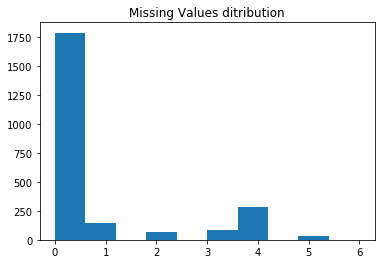

In [321]:
plt.title("Missing Values ditribution")
plt.hist(data.isnull().sum(axis = 1).values)
plt.show()

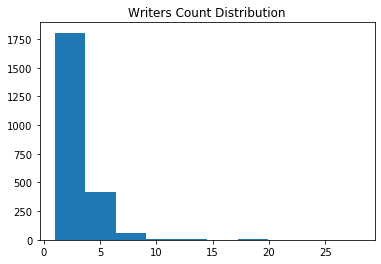

In [322]:
plt.title("Writers Count Distribution")
plt.hist(data['writer_count'])
plt.show()

In [323]:
print('Average Writer Count:',data['writer_count'].mean())

Average Writer Count: 2.596270598438855


#### Lets impute the writer missing values with the lower side of the avergae ie., 2 

In [324]:
data['writer_count'] = data['writer_count'].fillna(2)
test['writer_count'] = test['writer_count'].fillna(2)

#### Imputing Censor Rating

In [325]:
data['censor_rating'].value_counts()

R            971
PG-13        727
PG           276
Not Rated    262
G             53
NOT RATED     36
Unrated       26
UNRATED       11
Name: censor_rating, dtype: int64

#### We can observe unrated has represented in multiple ways. Lets normalize that and we can also fill missing values as unrated.

In [326]:
def fill_censor_rating(x):
    d = {'R':1,'PG-13':2,'PG':3,'G':4}
    if x not in ['R','PG-13','PG','G']:
        return 0
    else:
        return d[x]

data['censor_rating'] = data['censor_rating'].apply(lambda x : fill_censor_rating(x))
test['censor_rating'] = test['censor_rating'].apply(lambda x : fill_censor_rating(x))

#### Imputing Nulls and handling Outliers for User Behaviour fields like comments,likes,overall_views,dislikes              

##### Mean and Std of the variables

In [327]:
print("Dislikes:",np.mean(data[data['dislikes']>0]['dislikes']),np.std(data[data['dislikes']>0]['dislikes']))
print("overall_views:",np.mean(data[data['overall_views']>0]['overall_views']),np.std(data[data['overall_views']>0]['overall_views']))
print("likes:",np.mean(data[data['likes']>0]['likes']),np.std(data[data['likes']>0]['likes']))
print("comments:",np.mean(data[data['comments']>0]['comments']),np.std(data[data['comments']>0]['comments']))


Dislikes: 244.93756727664154 969.1258916927679
overall_views: 1345471.603456553 4029950.607123282
likes: 3118.6774193548385 10218.09884637013
comments: 586.8710554951034 2174.277013708139


These variation in the data is very high. Lets try to generalise the data with respect to the normal 
distribution strategy. For a normal distribution the 99% of the data lies in the -3 to +3 std deviations away. 
Anyway we have zeros as the lower limit and we need to restrict the upper limit ie., handling outliers.

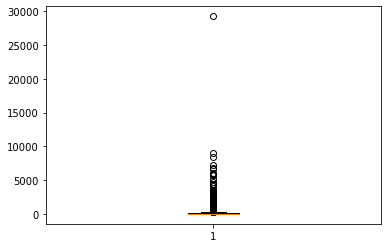

In [328]:
plt.boxplot(data[data['dislikes']>0]['dislikes'])
plt.show()

In [329]:
data[data['dislikes']>3152] = 3152  # 3152 is 3 std deviations by consdiering any datapoint away 3 std as outlier 
data['dislikes'] = data['dislikes'].fillna(245)

test[test['dislikes']>3152] = 3152  # 3152 is 3 std deviations by consdiering any datapoint away 3 std as outlier 
test['dislikes'] = test['dislikes'].fillna(245)

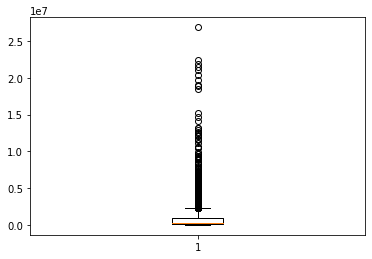

In [330]:
plt.boxplot(data[data['overall_views']>0]['overall_views'])
plt.show()

In [331]:
data[data['overall_views']>13435321] = 13435321  
data['overall_views'] = data['overall_views'].fillna(13435321)

test[test['overall_views']>13435321] = 13435321  
test['overall_views'] = test['overall_views'].fillna(13435321)

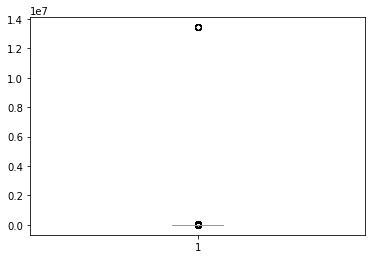

In [332]:
plt.boxplot(data[data['likes']>0]['likes'])
plt.show()

In [333]:
data[data['likes']>33773] = 33773  
data['likes'] = data['likes'].fillna(3119)

test[test['likes']>33773] = 33773  
test['likes'] = test['likes'].fillna(3119)

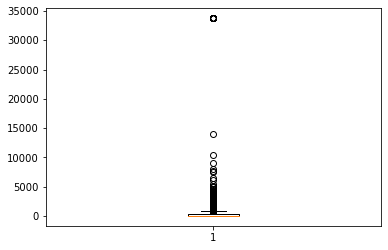

In [334]:
plt.boxplot(data[data['comments']>0]['comments'])
plt.show()

In [335]:
data[data['comments']>7108] = 7108  
data['comments'] = data['comments'].fillna(586)

test[test['comments']>7108] = 7108  
test['comments'] = test['comments'].fillna(586)

### Feature Creation

For Country, Langugage and Genere, the dimensionality is very high. So I would like to create the feature like 
the no of countries, no of languages and no of generes per movie

In [342]:
n_data = data[['country','genres','language','revenue_category']]

In [343]:
n_data['n_country'] = n_data['country'].apply(lambda x: len(str(x).split(',')))
n_data['n_genres'] = n_data['genres'].apply(lambda x: len(str(x).split(',')))
n_data['n_language'] = n_data['language'].apply(lambda x: len(str(x).split(',')))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [344]:
n_data.head(2)

,country,genres,language,revenue_category,n_country,n_genres,n_language
0,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,High,1,6,1
1,India,"Comedy, Drama, Musical, Romance","Hindi, English, French",Low,1,4,3


In [345]:
print("Averge between HIGH & LOW Categories for No.of Countries:",
      n_data[n_data['revenue_category']=='High']['n_country'].mean(),
      n_data[n_data['revenue_category']=='Low']['n_country'].mean())
print("Averge between HIGH & LOW Categories for No.of Genres:",
      n_data[n_data['revenue_category']=='High']['n_genres'].mean(),
      n_data[n_data['revenue_category']=='Low']['n_genres'].mean())
print("Averge between HIGH & LOW Categories for No.of Languages:",
      n_data[n_data['revenue_category']=='High']['n_language'].mean(),
      n_data[n_data['revenue_category']=='Low']['n_language'].mean())

Averge between HIGH & LOW Categories for No.of Countries: 1.598639455782313 1.728130360205832
Averge between HIGH & LOW Categories for No.of Genres: 3.1241496598639458 2.5042881646655233
Averge between HIGH & LOW Categories for No.of Languages: 1.6845238095238095 1.6586620926243567


In [346]:
data['no_country'] = data['country'].apply(lambda x: len(str(x).split(',')))
data['no_genres'] = data['genres'].apply(lambda x: len(str(x).split(',')))
data['no_language'] = data['language'].apply(lambda x: len(str(x).split(',')))

test['no_country'] = test['country'].apply(lambda x: len(str(x).split(',')))
test['no_genres'] = test['genres'].apply(lambda x: len(str(x).split(',')))
test['no_language'] = test['language'].apply(lambda x: len(str(x).split(',')))

### Creating Date Related Features like Month, Week, WeekDay release, Weekend release kind of feature

In [347]:
data['release_date'] = pd.to_datetime(data['release_date'])
data['dvd_release_date'] = pd.to_datetime(data['dvd_release_date'])

test['release_date'] = pd.to_datetime(test['release_date'])
test['dvd_release_date'] = pd.to_datetime(test['dvd_release_date'])

Relase Day Features

Features like Month, Week of the year, Weekday or not play a crucial role in the revenue generation of movies

In [348]:
data['release_month'] = data['release_date'].dt.month
data['release_week_of_year'] = data['release_date'].dt.week
data['is_release_weekday'] = data['release_date'].dt.weekday

test['release_month'] = test['release_date'].dt.month
test['release_week_of_year'] = test['release_date'].dt.week
test['is_release_weekday'] = test['release_date'].dt.weekday

Release Day to DVD Release Day

In [349]:
data['release_distance'] = (data['dvd_release_date']-data['release_date']).dt.days

test['release_distance'] = (test['dvd_release_date']-test['release_date']).dt.days

In [350]:
data[data['release_distance']<0].head(2)

,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category,no_country,no_genres,no_language,release_month,release_week_of_year,is_release_weekday,release_distance
18,GasLand,USA,Documentary,English,1.0,False,0,2011-01-17,107,2010-12-14,"9,910",1732.0,7340.0,2430754.0,323.0,77.0,97.0,0.0,1,7,6,Low,1,1,1,1.0,3.0,0.0,-34.0
20,Sweetgrass,"France, UK, USA","Documentary, Adventure, Western",English,2.0,False,0,2011-04-22,101,2010-08-03,814,22.0,265.0,140425.0,9.0,69.0,97.0,80.0,0,1,10,Low,3,3,1,4.0,16.0,4.0,-262.0


I did not understand the case where DVD is released before the Movie release. So I am just dropping the release distance
column. Otherwise, for a movie running successfully will have a higher duration of DVD release.

In [351]:
data.drop('release_distance',inplace=True, axis=1)

test.drop('release_distance',inplace=True, axis=1)

And did not find much info on DVD release data for missing value imputation also

In [352]:
data.drop('dvd_release_date',inplace=True,axis=1)

test.drop('dvd_release_date',inplace=True,axis=1)

Dropping other NA's

In [353]:
data.dropna(inplace=True)

test.dropna(inplace=True)

### Convert all data to numerics

In [354]:
data.dtypes

title                           object
country                         object
genres                          object
language                        object
writer_count                   float64
title_adaption                  object
censor_rating                    int64
release_date            datetime64[ns]
runtime                          int64
users_votes                     object
comments                       float64
likes                          float64
overall_views                  float64
dislikes                       float64
ratings_imdb                   float64
ratings_tomatoes               float64
ratings_metacritic             float64
special_award                    int64
awards_win                       int64
awards_nomination                int64
revenue_category                object
no_country                       int64
no_genres                        int64
no_language                      int64
release_month                  float64
release_week_of_year     

In [355]:
def title_adaption(x):
    if x==True:
        return 1
    else:
        return 0
    
data['title_adaption'] = data['title_adaption'].apply(lambda x: title_adaption(x)) 
test['title_adaption'] = test['title_adaption'].apply(lambda x: title_adaption(x)) 

In [356]:
def user_votes(x):
    if type(x)==int:
        return float(x)
    else:
        return float(x.replace(',',''))

data['users_votes'] = data['users_votes'].apply(lambda x : user_votes(x))
test['users_votes'] = test['users_votes'].apply(lambda x : user_votes(x))


### Clean target Values as seen ['High', 'Low', 3152, 7108]

In [357]:
data['revenue_category'].value_counts()

High    1174
Low     1162
7108      32
3152      26
Name: revenue_category, dtype: int64

The positive and negative cases are well balanced. Need to drop those rows with wrong labels

In [358]:
data = data[data['revenue_category'].isin(['High','Low'])]

# Visualization, Modeling, Machine Learning

#Can you build a model that can help them predict what titles would be suitable for licensing and identify how different features influence their decision? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of accuracy.**
- **Read the test.csv file and prepare features for testing.**




**The management wants to know what are the most important features for your model.  Can you tell them?**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


#### Split Inputs & Target Variables

In [359]:
X = data.iloc[:,~data.columns.isin(['title','revenue_category','country','genres','language','release_date','dvd_release_date'])]
Y = data.iloc[:,data.columns.isin(['revenue_category'])]

In [371]:
Y['revenue_category'].value_counts()

High    1174
Low     1162
Name: revenue_category, dtype: int64

In [361]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Feature Importance

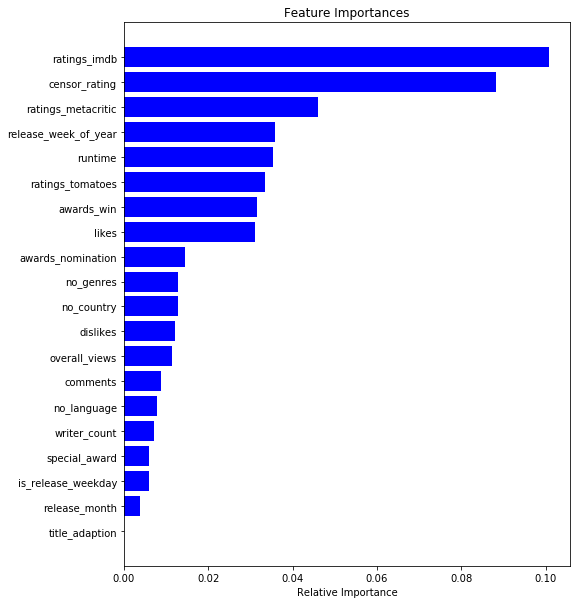

In [362]:

features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[0:20]


plt.figure(figsize=(8, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From the above plot we can clearly see that the obvious fetaures like ratings, awards, coverage playing the 
high importance of the movie revenue generation. Feature engineering has an impact, we can obseerve 
release_week_of_year is the top 4th highly influencing feature and no_genres,no_country,no_languages is also having a significant impact

### Building a Ensemblem Classifier

In [363]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

In [364]:
model = LGBMClassifier()

In [374]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Cross Validated Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Cross Validated Accuracy: 0.871 (0.020)


In [366]:
model.fit(X, Y)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), you must predict the value of the `revenue_category` variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:

The file (`submissions.csv`) should have exactly 2 columns:
   - **title**
   - **revenue_category**

In [367]:
submission_df = test.iloc[:,test.columns.isin(['title'])]
test = test.iloc[:,~test.columns.isin(['title','country','genres','language','release_date','dvd_release_date'])]

In [368]:
submission_df['revenue_category'] =  model.predict(test)

In [385]:
submission_df.head()

,title,revenue_category
0,Delhi-6,Low
1,Before I Disappear,Low
2,"Good Year, A",High
3,Brüno,High
4,How to Lose a Guy in 10 Days,High


In [379]:
test.shape

(598, 21)

In [ ]:
Actual test set size is 600 but I did not able to logic for the right way to impute missing value for 
release date so I dropped it for time being

In [384]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---